In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from cpymad.madx import Madx
import urllib

from IPython.core.display import display, HTML, Markdown

display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

def printmd(string):
    display(Markdown(string))

pd.set_option('display.max_rows', None)
plt.ion()


This notebook shows how the linac to SPS transfer line concept was studied. Note that the result is not perfect has the goal was to validate the concept, investigate possible use of existing magnets available in the CERN storage and evaluate costs. Further study and optimisation is needed for the technical implementation and design step. 

The results of this study were dscussed in a Letter od Intent submitted to the SPS scientific comittee and available [here](https://cds.cern.ch/record/2640784/files/SPSC-EOI-018.pdf)

# TI2 line

Fast extraction from the SPS long straight section 6 tansfers beam to the TT60 tunnel and towards wither the HighRadMAt experimental area or towards the LHC.

 <img src="./ressources/layout_overview.png" style="width: 900px;"/>
 
 
 The concept is as follows
 - an electron linac will be placed in an existing building in the surface, in direct line with the TT60 tunnel, not showed in the figure above it would be far to the left
 - an electron beam transport line will be installed from the linac an connect to one of the existing lines for a fast injection into the SPS ring
 
 Note that in this concept, electrons would circulate opposite to the direction of hadrons. Electrons being negatively charged both direction and charge will be reversed wich means that optics and trajectory of the beam would be the same as for hadrons without needing to reverse any magnetic fields
 
 We will start by loading the stitched SPS+TI2 extraction line optics from the CERN accelerator optics repository [here](https://acc-models.web.cern.ch/acc-models/tls/2021/sps_extraction/tt60ti2_q26/stitched/)

In [2]:
# initialization of the madx object
madx = Madx()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2020.12.17 14:54:48      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [3]:
# cloning the optics repositories
! git clone -n https://gitlab.cern.ch/acc-models/acc-models-tls.git
! cd acc-models-tls ; git checkout 7495fbaa1b7f4006258e9145e864ac02d25a1762

! git clone -n https://gitlab.cern.ch/acc-models/acc-models-sps.git
! cd acc-models-sps ; git checkout 32b347a0198dd17ee6009198857520b43413a39c

fatal: destination path 'acc-models-tls' already exists and is not an empty directory.
HEAD is now at 7495fba Increased expiration time for artifacts
fatal: destination path 'acc-models-sps' already exists and is not an empty directory.
HEAD is now at 32b347a update actions


Now, with some minor changes, we will copy and run the commands used in the file `acc-models-tls/sps_extraction/tt60ti2_q26/stitched/general_sps_ti2_lhc_q26.madx` which is used to generate the stitched extraction optics from the SPS to the LHC, and the data used [in this plot](https://acc-models.web.cern.ch/acc-models/tls/2021/sps_extraction/tt60ti2_q26/stitched/), and created by F.M. Velotti.

The aim here is get the stitched sequence, but with only the optics and for now ignoring the extracted trajectory.

In [4]:
sps_extr_repo = 'acc-models-tls/sps_extraction/sps_ext_elements'
ti2_repo = 'acc-models-tls/sps_extraction/tt60ti2'
ti2_line_repo = 'acc-models-tls/sps_extraction/tt60ti2_q26/line'
tt60ti2_q26 = 'acc-models-tls/sps_extraction/tt60ti2_q26/stitched'
sps_repo = 'acc-models-sps'

madx.input('''
! MADX model of SPS-TT60-TI2 for LHC Q26 optics
!
! F.M.Velotti
!====================================================
 title, "SPS-TT60-TI2 LHC Q26 optics. Protons - 450 GeV/c";

 option, -echo;
 option, RBARC=FALSE;

 set, format="22.8e";
''')

madx.call(ti2_repo+'/ti2.seq')
madx.call(ti2_repo+'/ti2_apertures.dbx')
madx.call(ti2_line_repo+'/ti2_q26.str')

madx.input('''
beam,    sequence=ti2, particle=proton, pc= 450;
use,     sequence=ti2;

ex_g = beam->ex;
ey_g = beam->ey;
dpp = 1.5e-3;
''')
madx.call(ti2_repo+'/mbi_b3_error.madx')

Assigned field errors to 112 elements


In [5]:
madx.use('ti2')
# loading initial twiss parameters and transporting them along the ti2
madx.call(tt60ti2_q26+'/sps_tt60_ti2_lhc_q26.inp')
twiss_ti2 = madx.twiss(betx=madx.globals['betx0'], alfx=madx.globals['alfx0'], bety=madx.globals['bety0'], alfy=madx.globals['alfy0'], dx=madx.globals['dx0'], dpx=madx.globals['dpx0']).dframe()

#saving the length of that sequence
madx.globals['ti2_length'] = madx.table['summ'].length[0]

enter Twiss module

++++++ table: summ

                length                 orbit5                   alfa                gammatr 
        3.18838428e+03        -0.00000000e+00         0.00000000e+00         0.00000000e+00 

                    q1                    dq1                betxmax                  dxmax 
        1.20391740e+01         0.00000000e+00         2.79993231e+02         3.09275960e+00 

                 dxrms                 xcomax                 xcorms                     q2 
        1.41797143e+00         5.76586492e-16         2.12296565e-16         1.21801704e+01 

                   dq2                betymax                  dymax                  dyrms 
        0.00000000e+00         2.67287068e+02         3.95261548e+00         5.52430980e-01 

                ycomax                 ycorms                 deltap                synch_1 
        5.99686734e-16         2.19988765e-16         0.00000000e+00         0.00000000e+00 

               synch_2   

In [6]:
madx.call(sps_repo+'/sps.seq')
madx.call(sps_repo+'/strengths/lhc_q26.str')
madx.call(sps_extr_repo+'/fast_extraction_macros.cmdx')

madx.input('''
Beam, particle=PROTON,pc=450,exn=3.5e-6,eyn=3.5E-6;
BRHO      := BEAM->PC * 3.3356;

ex_g = beam->ex;
ey_g = beam->ey;
dpp = 1.5e-3;

use, sequence=SPS;

exec, install_extraction_points();

! Cycle machine to end at extraction point in LSS6
SEQEDIT, sequence=SPS;
CYCLE, START=EXTRPT_6_start;
FLATTEN;
ENDEDIT;

use, sequence = sps;

savebeta, label=extracting, place = EXTRPT_6_START;
twiss;
exec, replace_quad(qda.61910, qda.619.coil);
qda.619.coil, k1 :=  -0.16 * kqda;
''')
madx.globals['sps_length'] = madx.table['summ'].length[0]

++++++ info: element redefined: btv
++++++ info: element redefined: mbb
++++++ info: ex_g redefined
++++++ info: ey_g redefined
++++++ info: dpp redefined
++++++ info: seqedit - number of elements installed:  4
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
enter Twiss module

++++++ table: summ

                length                 orbit5                   alfa                gammatr 
        6.91150380e+03        -0.00000000e+00         1.92815906e-03         2.27734366e+01 

                    q1                    dq1                betxmax                  dxmax 
        2.61300000e+01         8.33861168e-03         1.04069405e+02         

We have loaded both the ti2 and the sps seuquence, we can now stich them together

In [7]:
madx.input('''
sps_ti2: sequence, refer=entry, l= sps_length + ti2_length;
  sps, at=0;
  ti2, at=sps_length;
  endsequence;
''')


madx.use('sps_ti2')
twiss_sps_ti2 = madx.twiss(beta0='extracting').dframe()

enter Twiss module
 Found 6 initial orbit vector values from twiss command. 

++++++ table: summ

                length                 orbit5                   alfa                gammatr 
        1.00998881e+04        -0.00000000e+00         0.00000000e+00         0.00000000e+00 

                    q1                    dq1                betxmax                  dxmax 
        3.81704717e+01         0.00000000e+00         2.81022398e+02         4.76777511e+00 

                 dxrms                 xcomax                 xcorms                     q2 
        2.16521363e+00         5.76586492e-16         9.04283321e-17         3.83607205e+01 

                   dq2                betymax                  dymax                  dyrms 
        0.00000000e+00         2.67648155e+02         3.95261508e+00         2.34971349e-01 

                ycomax                 ycorms                 deltap                synch_1 
        5.99686734e-16         9.35951335e-17         0.00000

We can now plot the complete optics of the SPS followed by the TI2 line and up to the LHC. However, the plot bellow limits to the region around the extraction to make it more clear.

In [8]:
def plot_this_twiss(fig, twiss):
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[1, 4, 4])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)

    # top plot is synoptic
    ax1.axis('off')
    ax1.set_ylim(-1.2, 1)
    ax1.plot([0, twiss['s'].max()], [0, 0], 'k-')

    for _, row in twiss[twiss['keyword'].str.contains('quadrupole|rbend|sbend')].iterrows():
        if row['keyword'] == 'quadrupole':
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s']-row['l'], 0), row['l'], np.sign(row['k1l']),
                    facecolor='k', edgecolor='k'))
        elif (row['keyword'] == 'rbend' or 
              row['keyword'] == 'sbend'):
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s']-row['l'], -1), row['l'], 2,
                    facecolor='None', edgecolor='k'))

    #2nd plot is beta functions
    ax2.set_ylabel(r'$\beta$ (m)')
    ax2.plot(twiss['s'], twiss['betx'], 'r-')
    ax2.plot(twiss['s'], twiss['bety'], 'b-')        

    #3rd plot is dispersion functions
    ax3.set_ylabel('D (m)')
    ax3.plot(twiss['s'], twiss['dx'], 'r-')
    ax3.plot(twiss['s'], twiss['dy'], 'b-')

    axnames = ax1.twiny()
    axnames.spines['top'].set_visible(False)
    axnames.spines['left'].set_visible(False)
    axnames.spines['right'].set_visible(False)
    ax1._shared_x_axes.join(ax1, axnames)

    ticks, ticks_labels = list(), list()
    for keyword in ['quadrupole', 'rbend', 'sbend']:
        sub_twiss = twiss[twiss['keyword'] == keyword]
        ticks += list(sub_twiss['s'])
        ticks_labels += list(sub_twiss.index)

    axnames.set_xticks(ticks)
    axnames.set_xticklabels(ticks_labels, rotation=90)

    ax3.set_xlabel('s (m)')

    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    ax1.set_xlim(twiss['s'].min(), twiss['s'].max())

<IPython.core.display.Javascript object>


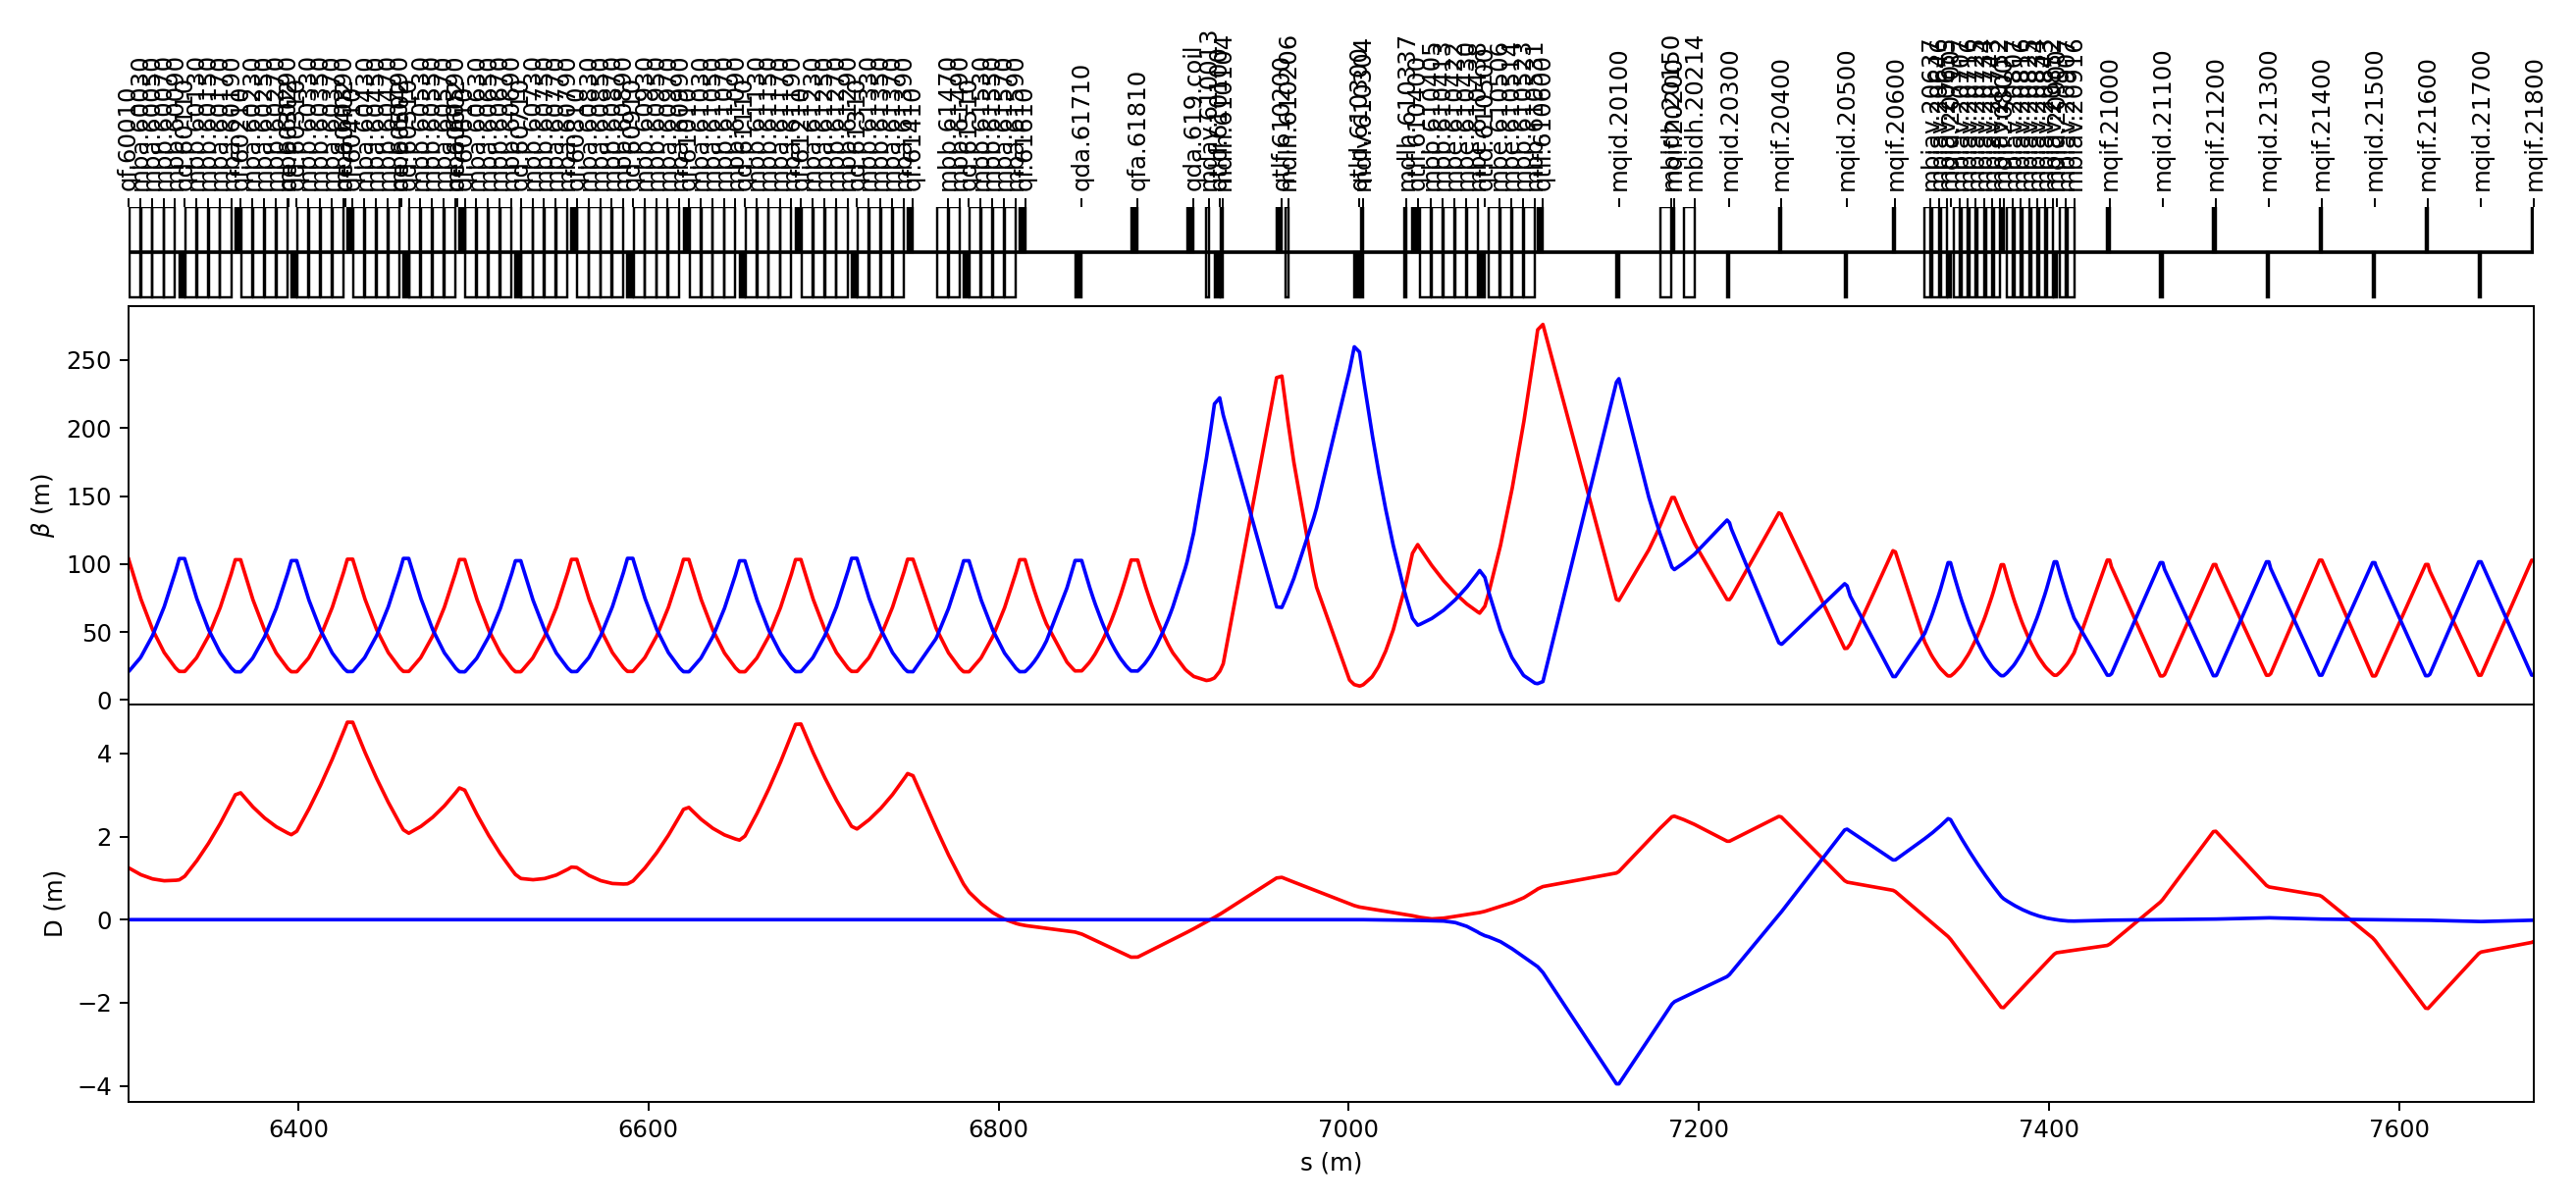

In [9]:
fig = plt.figure(figsize=(15,7))
plot_this_twiss(fig, twiss_sps_ti2.loc['qf.60010':'mqif.21800'])    

Now we will isolate the relevant part of the line, from the extraction point os the SPS labelled `EXTRPT_6` to where I decided to join the new beamline, downstream of the vertical corrector `MCIAV.20304` where I will place a marker named `END_SHARE_TI2`

In [10]:
twiss_forward_extrpt_6 = twiss_sps_ti2.loc['extrpt_6']
twiss_forward_end_share_ti2 = twiss_sps_ti2.loc['mciav.20304']

madx.command.seqedit(sequence='sps_ti2')
madx.command.flatten()
madx.command.install(element='END_SHARE_TI2', class_='marker', at=madx.elements['mciav.20304']['l']/2, from_='MCIAV.20304')
# madx.input('install, element=END_SHARE_TI2, class=marker, at=l.mciav/2, from=mciav.20304')
madx.command.flatten()
madx.command.endedit()

++++++ info: seqedit - number of elements installed:  1
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [11]:
madx.use('sps_ti2')                 
madx.extract(sequence='sps_ti2', from_='extrpt_6', to='END_SHARE_TI2', newname='sps_to_handover')
madx.globals['sps_to_handover.l'] = twiss_forward_end_share_ti2['s']-twiss_forward_extrpt_6['s']


+++ extracting sequence sps_ti2 from extrpt_6:1 to end_share_ti2:1
+++ new sequence: sps_to_handover  with current length = 306.99798



enter Twiss module

++++++ table: summ

                length                 orbit5                   alfa                gammatr 
        3.06997980e+02        -0.00000000e+00         0.00000000e+00         0.00000000e+00 

                    q1                    dq1                betxmax                  dxmax 
        8.66906852e-01         0.00000000e+00         2.76239697e+02         2.49217307e+00 

                 dxrms                 xcomax                 xcorms                     q2 
        1.05248723e+00         1.19570262e-17         6.56415659e-18         6.84609332e-01 

                   dq2                betymax                  dymax                  dyrms 
        0.00000000e+00         2.59773520e+02         3.95261508e+00         1.16972258e+00 

                ycomax                 ycorms                 deltap                synch_1 
        1.12341461e-24         4.40874823e-25         0.00000000e+00         0.00000000e+00 

               synch_2   

<IPython.core.display.Javascript object>


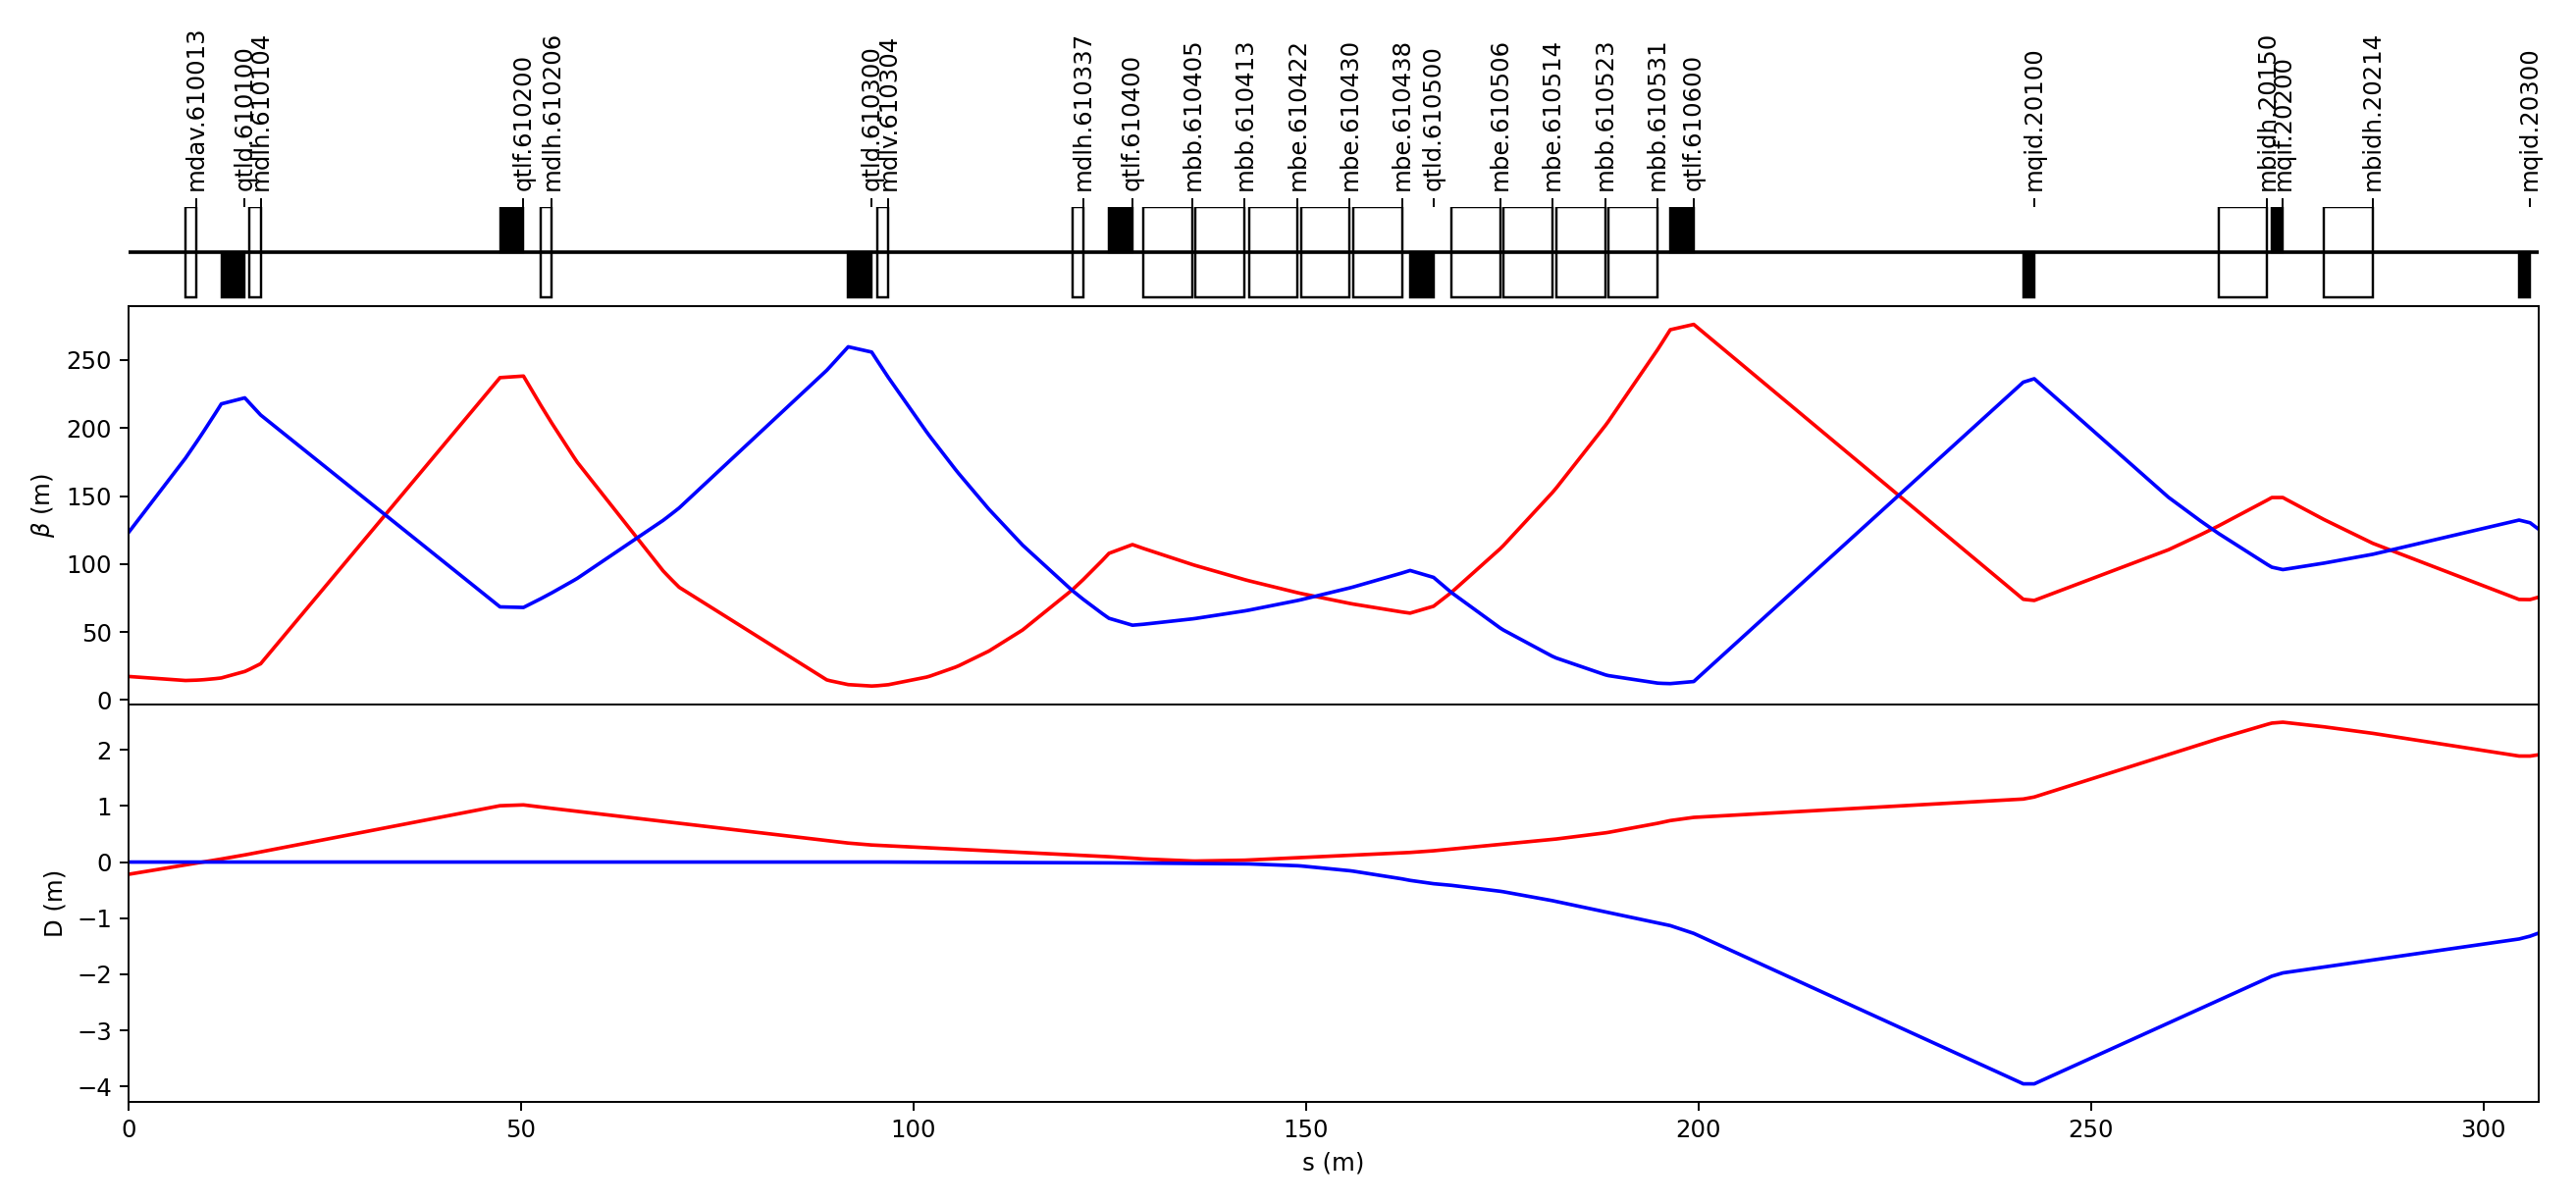

In [12]:
madx.use('sps_to_handover')
twiss_forward = madx.twiss(betx=twiss_forward_extrpt_6['betx'], alfx=twiss_forward_extrpt_6['alfx'], bety=twiss_forward_extrpt_6['bety'], alfy=twiss_forward_extrpt_6['alfy'], 
                           dx=twiss_forward_extrpt_6['dx'], dpx=twiss_forward_extrpt_6['dpx']).dframe()

fig = plt.figure(figsize=(15,7))
plot_this_twiss(fig, twiss_forward)    

## backward transport

In this project we aim at transporting the beam in the opposite direction. What does that entail and require on the model side ? Understand this and use MADX to produce the transport of the twiss parameters in the backward direction.

Use also the **SURVEY** module of MADX to see the position of elements in real space and make sure your reversal of the line also follow correctly real space !

## New line design

In our case the design of a new line will be done in 2 major steps, the geometry using dipoles and the control of the enveloppe using quadrupoles.

First use the magnet specifications provided and process the data to compare them, and chose the ones best suited to our application. This comparison should in particular show the maximum angle for dipoles and estimated minimum focal length for quadriupoles.

### geometrry

The geometry is constrainted by an existing tunnel (see ressources folder for drawing). This constraints the angle and location of dipole magnets that will impose the position of the vacuum chamber and the trajectory of the reference particle. Note that civil engineering is usually expensive, hence re-using exisinting tunnel or structure is optimal.

You may investigate the required geometry using the drawing provided. However, finding the needed trajectory requires more informations than those provided by the historical drawings. Therefore I list below the sequence needed :
 - handhover point of the beam from the linac.
 - 35 m of straight line
 - horizontal angle, towards the left, of 60.9 mrad
 - 60 m of straight line
 - vertical angle of 162 mrad, downwards
 - 326 m of straight line
 - vertical angle of 9.6 mrad, upwards
 - 109 m of straight line
 - vertical angle of 40.5 mrad, upwards
 - 71 m of straight line
 - horizontal angle, towards the left, of 34.3 mrad. This will place the trajectory in the axis of the line at the `END_SHARE_TI2` handover point
 - 1 m of straight line that will bring the line to the location of the handover marker
 
 



### envelope transport

The linac outputs a beam with a shape typical of a FODO cell with phase advance of 90 degrees, length of 5.3 m that ends on the focusing quadrupole. You should find an $\beta_x \simeq 9$ and $\beta_y \simeq 1.5$. This beam also has a relative momentum spread in the order of $10^{-3}$.

You should find the best arrangement of quadrupoles that transports and matches this beam to the handover point. The best arrangement uses the least number of quadrupoles, the smallest ones, and matches perfectly to the beam parameters at the handover point, in that order of priority.